In [113]:
#!pip install --user pyarrow
#!pip install --user -U pandas

In [11]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [12]:
conservation = pd.read_csv("../data/vep/conservation/Chr5.tsv.gz", sep="\t")
conservation

,pos,PhastCons,PhyloP
0,73,0.137841,0.486723
1,74,0.120058,0.630370
2,75,0.082986,-0.672660
3,76,0.083501,0.630370
4,77,0.070315,0.410230
...,...,...,...
24279498,26975493,0.149043,0.383414
24279499,26975494,0.139126,0.383414
24279500,26975495,0.121064,-0.819180
24279501,26975496,0.144156,0.383414


In [13]:
#repeats = pd.read_csv("../data/mlm/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
#repeats = repeats.query('chrom == "Chr5"')
#repeats

In [14]:
def compute_odds_ratio(df, threshold_quantile, print_table=False, bootstrap_seed=None):
    df = df.copy()
    if bootstrap_seed is not None:
        df = df.sample(frac=1.0, replace=True, random_state=bootstrap_seed)
    threshold = df.model_score.quantile(threshold_quantile)
    df.loc[df.model_score <= threshold, "ModelScoreTier"] = "Low"
    df.loc[df.model_score > threshold, "ModelScoreTier"] = "High"
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    
    #print("Adding 1 pseudocount")
    #group_counts += 1
    if print_table:
        print(group_counts)
    
    group_counts2 = group_counts.copy()
    #print(threshold_quantile, threshold, group_counts["Rare", "Low"]+group_counts["Common", "Low"], df.model_score.min())
    group_counts = group_counts.values.reshape((2, 2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts


def compute_vep_scores(model_name):
    print(model_name)
    if model_name in ["PhastCons", "PhyloP", "PhyloP_ReLU", "PhyloP_abs"]:
        df = pd.read_parquet("../data/vep/variants/filt.parquet")
    else:
        vep_mode, model_name2 = model_name.split("/")
        df = pd.read_parquet(f"../plantbert/{vep_mode}/vep_full_{model_name2}.parquet")
    df = df[df.AN >= 2000]
    df = df[(df.AC != 0) & (df.AC != df.AN)]
    df["AF"] = df.AC / df.AN
    df = df[df.AF < 0.5]
    df = df.merge(conservation, how="inner", on="pos")
    df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))
    
    #df["chrom"] = df.chromosome
    #df["start"] = df.pos
    #df["end"] = df.start + 1
    #df = bf.coverage(df, repeats)
    #print(df.shape)
    #df = df.query('coverage == 0')
    #print(df.shape)
    
    # TODO: figure this out
    #df.loc[(df.dist_to_TSS >= -1000) & (df.dist_to_TSS <= 0) & (df.consequence=="upstream_gene_variant"), "consequence"] = "upstream_1kb"
    
    # TODO: for loop
    #rare_thresholds = np.arange(2, 12, 2)
    #common_thresholds = np.arange(10, 110, 10)
    
    df["Status"] = "Neither"
    df.loc[df.AC <= 2, "Status"] = "Rare"
    df.loc[df.AC >= 20, "Status"] = "Common"
    df = df[df.Status!="Neither"]
    df.Status = df.Status.astype('category')
    #raise Exception("debug")
    
    if model_name == "PhastCons":
        df["model_score"] = -df.PhastCons
    elif model_name == "PhyloP":
        df["model_score"] = -(df.PhyloP)
    elif vep_mode == "chromatin":
        pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
        pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
        pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
        df[pred_cols] = sigmoid(df[pred_cols])
        feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
        delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
        df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
        df.loc[:, "model_score"] = -np.linalg.norm(df[delta_pred_cols].abs().values, ord=2, axis=1)
        df.drop(columns=np.concatenate([pred_cols, delta_pred_cols]), inplace=True)
    elif vep_mode == "mlm":
        df["model_score"] = df.model_llr
        
    threshold_quantiles = np.logspace(-3, -1, 10)
    bootstrap_seeds = np.arange(30)
    
    categories = ["all"] + df.consequence.value_counts()[:8].index.values.tolist()
    
    all_results = []
    for category in categories:
        #print(category)
        df_category = df if category == "all" else df[df.consequence==category]
        
        odds_ratios, p_values, min_counts = zip(*[compute_odds_ratio(df_category, threshold_quantile) for threshold_quantile in threshold_quantiles])
        results = pd.DataFrame(dict(threshold_quantile=threshold_quantiles, odds_ratio=odds_ratios, p_value=p_values, min_count=min_counts))
        results["Test"] = "Odds-ratio"
        
        
        for bootstrap_seed in bootstrap_seeds:
            odds_ratios = [compute_odds_ratio(df_category, threshold_quantile, bootstrap_seed=bootstrap_seed)[0] for threshold_quantile in threshold_quantiles]
            #print(odds_ratios)
            #raise Exception("debug")
            results = pd.concat([
                results,
                pd.DataFrame({
                    "Test": ["Odds-ratio-bootstrap"] * len(threshold_quantiles),
                    "threshold_quantile": threshold_quantiles,
                    "bootstrap_seed": [bootstrap_seed] * len(threshold_quantiles),
                    "odds_ratio": odds_ratios,
                    "p_value": p_values, "min_count": min_counts,  # from the non-bootstrapped test
                })],
                ignore_index=True
            )
            #print(results)
            #raise Exception("debug")
        
        results = results.append({
            "Test": "Mann-Whitney",
            "p_value": mannwhitneyu(df_category.loc[df.Status=="Rare", "model_score"], df_category.loc[df.Status=="Common", "model_score"], alternative="less").pvalue
        }, ignore_index=True)
        
        results = results.append({
            "Test": "AUROC",
            "AUROC": roc_auc_score((df_category.Status=="Rare").values, -df_category.model_score.values)
        }, ignore_index=True)
        
        precision, recall, thresholds = precision_recall_curve((df_category.Status=="Rare").values, -df_category.model_score.values)
        results = results.append({
            "Test": "AUPRC",
            "AUPRC": auc(recall, precision),
        }, ignore_index=True)
        
        results["Category"] = category
        all_results.append(results)
    all_results = pd.concat(all_results, ignore_index=True)
    all_results["Model"] = model_name
    all_results["Significant"] = all_results.p_value < 0.05
    
    return all_results, df

In [20]:
model_names = [
    #"mlm/ensemble_3.avg",
    #"mlm/ensemble_3.min",
    "mlm/results_512_convnet_checkpoint-1000000",
    "mlm/results_512_convnet_ftAth_alone_checkpoint-100000",
    "mlm/results_512_convnet_ftAth_alone_checkpoint-800000",
    #"mlm/window-512_tokenization-no_model-convnet200k",
    #"mlm/window-512_tokenization-no_model-convnet",
    #"mlm/window-512_tokenization-no_model-convnet800k",
    #"mlm/window-512_tokenization-no_model-convnet800kfinetune150k",
    #"mlm/window-512_tokenization-no_model-convnet800kfinetune200k",
    #"mlm/window-512_tokenization-no_model-convnet_only_athaliana",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth_alone",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth_alone",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth",
    #"mlm/DNABERT",
    #"chromatin/ConvNet",
    #"chromatin/DNABERT",
    #"chromatin/DeepSEA",
    #"PhastCons",
    #"PhyloP",
]

results = pd.concat(
    [compute_vep_scores(model_name)[0] for model_name in model_names],
    ignore_index=True
)

mlm/results_512_convnet_checkpoint-1000000
(1319370, 17)
(1254284, 17)


/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/scratch/projects/fc_songlab/gbenegas/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


mlm/results_512_convnet_ftAth_alone_checkpoint-100000
(1319370, 17)
(1254284, 17)


/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/scratch/projects/fc_songlab/gbenegas/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


mlm/results_512_convnet_ftAth_alone_checkpoint-800000
(1319370, 17)
(1254284, 17)


/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/scratch/projects/fc_songlab/gbenegas/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
#results.to_csv(f"vep_metrics_2_20_bootstrap30_norepeats.tsv", sep="\t", index=False)
#results = pd.read_csv("vep_metrics_2_20_bootstrap.tsv", sep="\t")

In [45]:
results

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
0,0.001000,1.941598,4.476473e-21,258.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet800k,True
1,0.001668,2.097214,4.566975e-41,407.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet800k,True
2,0.002783,2.023607,1.513236e-61,697.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet800k,True
3,0.004642,1.989525,7.475513e-97,1178.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet800k,True
4,0.007743,1.830331,3.318833e-126,2087.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet800k,True
...,...,...,...,...,...,...,...,...,...,...,...
82048,0.059948,1.132850,3.208121e-06,703.0,Odds-ratio-bootstrap,99.0,NaN,NaN,downstream_gene_variant,PhyloP,True
82049,0.100000,1.134755,2.777936e-07,1221.0,Odds-ratio-bootstrap,99.0,NaN,NaN,downstream_gene_variant,PhyloP,True
82050,NaN,NaN,1.744197e-26,NaN,Mann-Whitney,NaN,NaN,NaN,downstream_gene_variant,PhyloP,True
82051,NaN,NaN,NaN,NaN,AUROC,NaN,0.535136,NaN,downstream_gene_variant,PhyloP,False


In [55]:
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet200k": "mlm/ConvNet-200k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet": "mlm/ConvNet-400k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet-800k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune150k": "mlm/ConvNet-finetune-athaliana"}, inplace=True)
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "mlm/ConvNet"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "ConvNet (800k 20 species + 200k only Arabidopsis)"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet_only_athaliana": "ConvNet (500k only Arabidopsis)"}, inplace=True)

In [56]:
# deal with infinite odds ratio
results.odds_ratio.max()

23.12856157478644

In [24]:
#results.odds_ratio.replace({np.inf: 20.0}, inplace=True)

In [25]:
#results.odds_ratio.max()

4.047146289496351

In [72]:
#results = results[~(results.Model.isin(["PhyloP_abs", "PhyloP_ReLU"]))]

In [73]:
#results = results[results.Model.str.contains("mlm/ConvNet")]

In [6]:
#results = results[~results.Model.str.contains("00k")]

In [4]:
df = compute_vep_scores("mlm/window-512_tokenization-no_model-convnet800kfinetune200k")[1]

mlm/window-512_tokenization-no_model-convnet800kfinetune200k
Rare      512513
Common    394733
Name: Status, dtype: int64


In [8]:
consequence_value_counts = df.consequence.value_counts()

In [9]:
def get_category_n(category):
    if category == "all": return len(df)
    return consequence_value_counts[category]

In [27]:
results["category_n"] = results.Category + " (n=" + results.Category.apply(get_category_n).astype(str) + ")"
results.category_n

0                         all (n=907246)
1                         all (n=907246)
2                         all (n=907246)
3                         all (n=907246)
4                         all (n=907246)
                     ...                
346    downstream_gene_variant (n=30852)
347    downstream_gene_variant (n=30852)
348    downstream_gene_variant (n=30852)
349    downstream_gene_variant (n=30852)
350    downstream_gene_variant (n=30852)
Name: category_n, Length: 351, dtype: object

In [37]:
results

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
0,0.001000,2.499754,3.484416e-36,214.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
1,0.001668,2.393001,2.129182e-54,369.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
2,0.002783,2.306881,5.628154e-83,633.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
3,0.004642,2.167365,2.113629e-119,1107.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
4,0.007743,2.017399,1.189218e-165,1948.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
...,...,...,...,...,...,...,...,...,...,...,...
769,0.059948,1.192584,NaN,NaN,Odds-ratio-bootstrap,2.0,NaN,NaN,downstream_gene_variant,PhyloP,False
770,0.100000,1.169115,NaN,NaN,Odds-ratio-bootstrap,2.0,NaN,NaN,downstream_gene_variant,PhyloP,False
771,NaN,NaN,1.744197e-26,NaN,Mann-Whitney,NaN,NaN,NaN,downstream_gene_variant,PhyloP,True
772,NaN,NaN,NaN,NaN,AUROC,NaN,0.535136,NaN,downstream_gene_variant,PhyloP,False


In [22]:
results.Model.replace({"mlm/results_512_convnet_checkpoint-1000000": "1M(all)"}, inplace=True)
results.Model.replace({"mlm/results_512_convnet_ftAth_alone_checkpoint-100000": "1M(all)->100K(arabidopsis)"}, inplace=True)
results.Model.replace({"mlm/results_512_convnet_ftAth_alone_checkpoint-800000": "1M(all)->800K(arabidopsis)"}, inplace=True)

In [75]:
results.Model.value_counts()

mlm/ensemble_3.avg            2817
mlm/ensemble_3.min            2817
1M(all)                       2817
1M(all)->100K(arabidopsis)    2817
1M(all)->800K(arabidopsis)    2817
Name: Model, dtype: int64

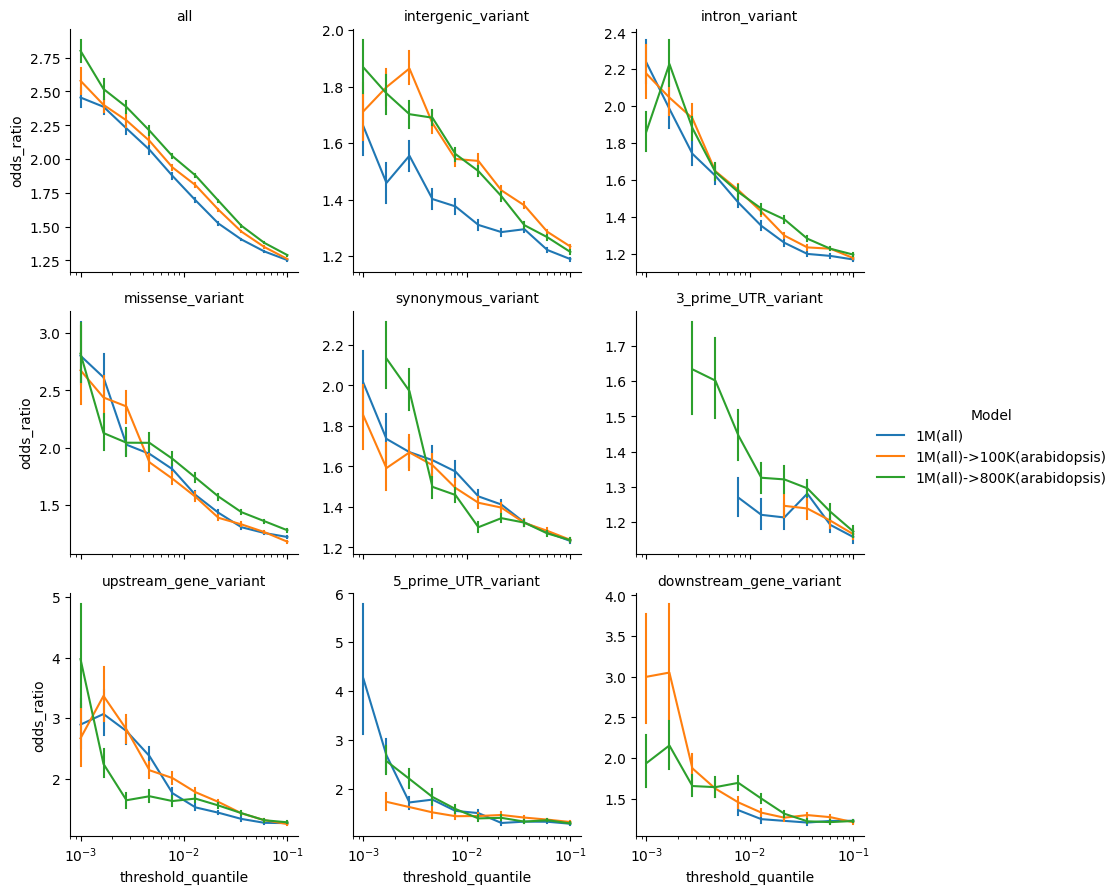

In [24]:
g = sns.relplot(
    #data=results[(results.Test=="Odds-ratio")&(results.min_count >= 5)],
    data=results[(results.Test=="Odds-ratio-bootstrap") & (results.Significant)],
    x="threshold_quantile",
    y="odds_ratio",
    hue="Model",
    #style="Significant",
    style_order=[True, False],
    #col="category_n",
    col="Category",
    height=3,
    #aspect=.7,
    kind="line",
    markers=True,
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True},
    err_style="bars",
    #err_style=None,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale='log');
#plt.savefig("odds_ratios.svg", bbox_inches='tight')
#plt.savefig("odds_ratios_3.pdf", bbox_inches='tight')

In [60]:
results_mw = results[results.Test=="Mann-Whitney"]
results_mw

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
310,NaN,NaN,0.000000e+00,NaN,Mann-Whitney,NaN,NaN,NaN,all,mlm/results_512_convnet_checkpoint-1000000,True
623,NaN,NaN,1.676546e-121,NaN,Mann-Whitney,NaN,NaN,NaN,intergenic_variant,mlm/results_512_convnet_checkpoint-1000000,True
936,NaN,NaN,1.504991e-42,NaN,Mann-Whitney,NaN,NaN,NaN,intron_variant,mlm/results_512_convnet_checkpoint-1000000,True
1249,NaN,NaN,3.424463e-80,NaN,Mann-Whitney,NaN,NaN,NaN,missense_variant,mlm/results_512_convnet_checkpoint-1000000,True
1562,NaN,NaN,6.209349e-71,NaN,Mann-Whitney,NaN,NaN,NaN,synonymous_variant,mlm/results_512_convnet_checkpoint-1000000,True
...,...,...,...,...,...,...,...,...,...,...,...
26915,NaN,NaN,2.948316e-187,NaN,Mann-Whitney,NaN,NaN,NaN,synonymous_variant,PhyloP,True
27228,NaN,NaN,6.256520e-59,NaN,Mann-Whitney,NaN,NaN,NaN,3_prime_UTR_variant,PhyloP,True
27541,NaN,NaN,9.207712e-45,NaN,Mann-Whitney,NaN,NaN,NaN,upstream_gene_variant,PhyloP,True
27854,NaN,NaN,6.744105e-62,NaN,Mann-Whitney,NaN,NaN,NaN,5_prime_UTR_variant,PhyloP,True


In [61]:
results_mw["-log10_pvalue"] = results_mw.p_value.apply(lambda p_value: 300 if p_value==0.0 else -np.log10(p_value))

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Mann-Whitney -log10_pvalue')

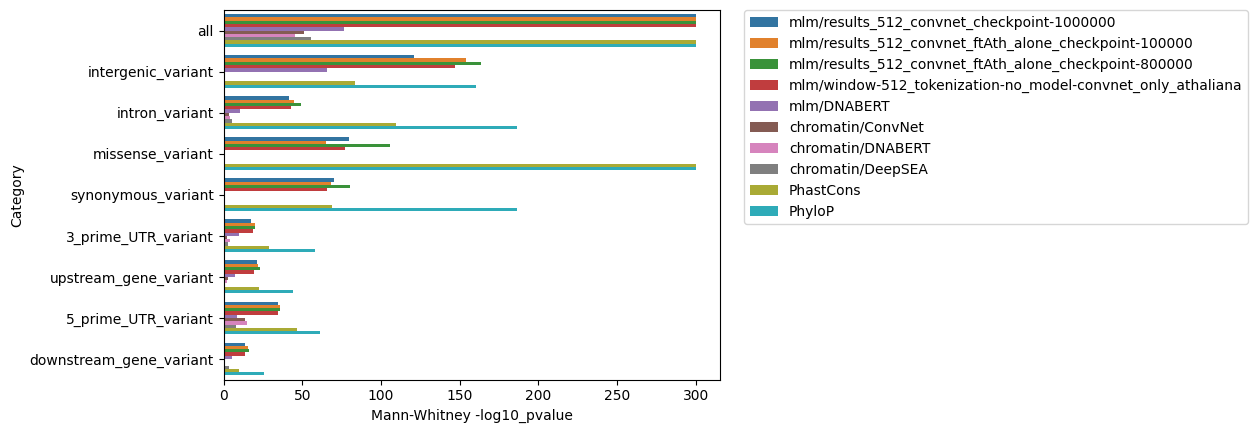

In [62]:
sns.barplot(
    y="Category",
    x="-log10_pvalue",
    hue="Model",
    data=results_mw,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Mann-Whitney -log10_pvalue")
#plt.savefig("mann_whitney.pdf", bbox_inches='tight')

In [63]:
results_auroc = results[results.Test=="AUROC"]
results_auroc

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
311,NaN,NaN,NaN,NaN,AUROC,NaN,0.531016,NaN,all,mlm/results_512_convnet_checkpoint-1000000,False
624,NaN,NaN,NaN,NaN,AUROC,NaN,0.526973,NaN,intergenic_variant,mlm/results_512_convnet_checkpoint-1000000,False
937,NaN,NaN,NaN,NaN,AUROC,NaN,0.519687,NaN,intron_variant,mlm/results_512_convnet_checkpoint-1000000,False
1250,NaN,NaN,NaN,NaN,AUROC,NaN,0.531798,NaN,missense_variant,mlm/results_512_convnet_checkpoint-1000000,False
1563,NaN,NaN,NaN,NaN,AUROC,NaN,0.533057,NaN,synonymous_variant,mlm/results_512_convnet_checkpoint-1000000,False
...,...,...,...,...,...,...,...,...,...,...,...
26916,NaN,NaN,NaN,NaN,AUROC,NaN,0.554254,NaN,synonymous_variant,PhyloP,False
27229,NaN,NaN,NaN,NaN,AUROC,NaN,0.545525,NaN,3_prime_UTR_variant,PhyloP,False
27542,NaN,NaN,NaN,NaN,AUROC,NaN,0.541741,NaN,upstream_gene_variant,PhyloP,False
27855,NaN,NaN,NaN,NaN,AUROC,NaN,0.553751,NaN,5_prime_UTR_variant,PhyloP,False


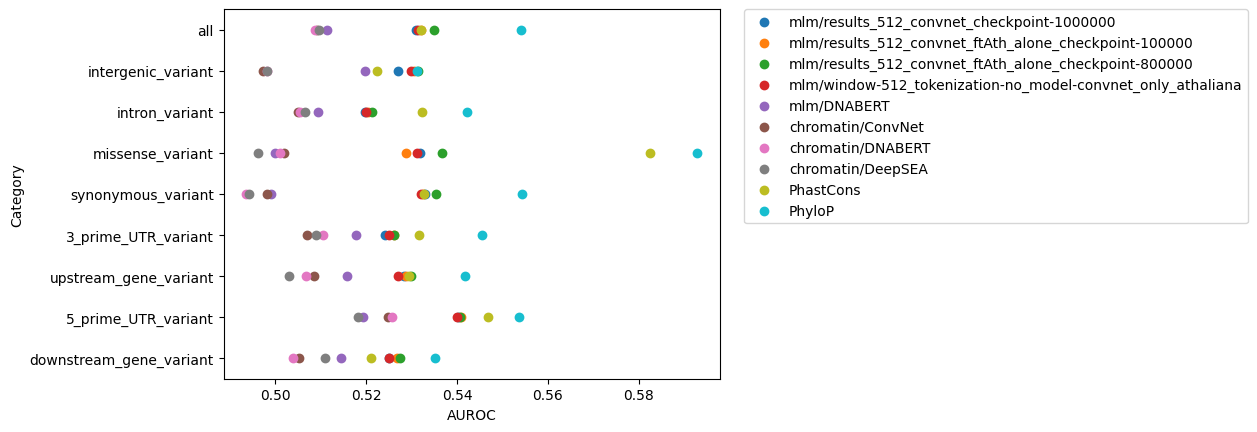

In [64]:
sns.pointplot(
    y="Category",
    x="AUROC",
    hue="Model",
    data=results_auroc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auroc.pdf", bbox_inches='tight')

In [65]:
results_auprc = results[results.Test=="AUPRC"]
results_auprc

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
312,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.593165,all,mlm/results_512_convnet_checkpoint-1000000,False
625,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.610200,intergenic_variant,mlm/results_512_convnet_checkpoint-1000000,False
938,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.545687,intron_variant,mlm/results_512_convnet_checkpoint-1000000,False
1251,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.653121,missense_variant,mlm/results_512_convnet_checkpoint-1000000,False
1564,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.497169,synonymous_variant,mlm/results_512_convnet_checkpoint-1000000,False
...,...,...,...,...,...,...,...,...,...,...,...
26917,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.515596,synonymous_variant,PhyloP,False
27230,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.600494,3_prime_UTR_variant,PhyloP,False
27543,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.612417,upstream_gene_variant,PhyloP,False
27856,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.626990,5_prime_UTR_variant,PhyloP,False


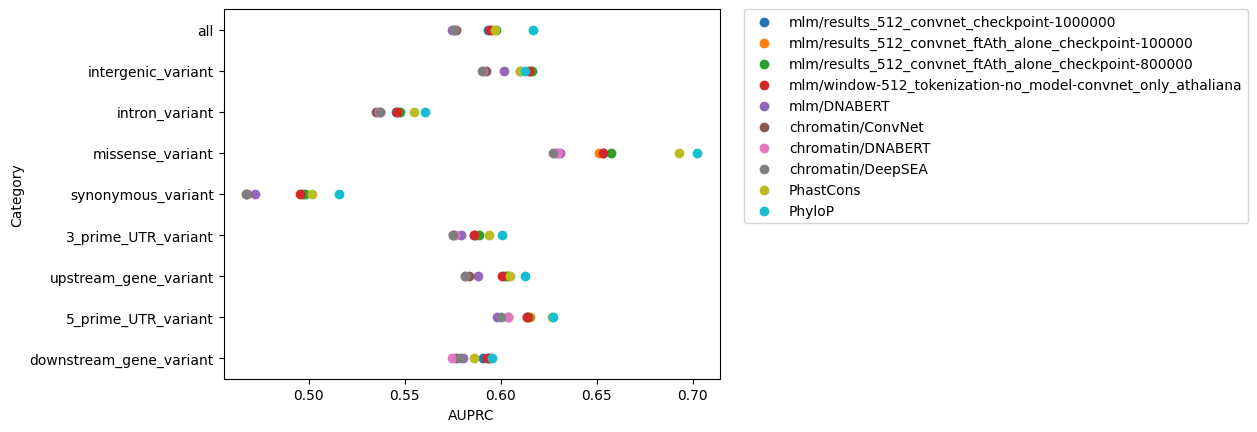

In [66]:
sns.pointplot(
    y="Category",
    x="AUPRC",
    hue="Model",
    data=results_auprc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auprc.pdf", bbox_inches='tight')

In [67]:
#df1 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half1_DNABERT.parquet")
#df2 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half2_DNABERT.parquet")
#df = pd.concat([df1, df2], ignore_index=True)
#df.to_parquet("../plantbert/chromatin/vep_full_DNABERT.parquet", index=False)

In [4]:
df = compute_vep_scores("mlm/window-512_tokenization-no_model-convnet800kfinetune200k")[1]
#df = compute_vep_scores("mlm/results_512_convnet_checkpoint-1000000",)
#df = compute_vep_scores("PhyloP")[1]
df

mlm/window-512_tokenization-no_model-convnet800kfinetune200k
Rare      512513
Common    394733
Name: Status, dtype: int64


,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.445963,0.180943,0.000041,-2.247958,Common,1.445963
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.122714,0.000958,0.005789,-0.031569,Rare,-1.122714
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.328421,0.000941,0.004241,0.006849,Rare,0.328421
5,Chr5,538,C,T,2,2158,AT5G01010.2,4456,intergenic_variant,-0.043589,0.000927,0.001401,-1.437007,Rare,-0.043589
6,Chr5,540,T,G,2,2194,AT5G01010.2,4454,intergenic_variant,-2.484268,0.000912,0.001881,0.066429,Rare,-2.484268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319359,Chr5,26974850,C,T,2,2028,AT5G67640.1,-4209,intergenic_variant,0.001271,0.000986,0.038742,-0.295663,Rare,0.001271
1319360,Chr5,26974862,G,A,2,2024,AT5G67640.1,-4221,intergenic_variant,1.164779,0.000988,0.440595,0.574454,Rare,1.164779
1319364,Chr5,26974883,A,C,2,2062,AT5G67640.1,-4242,intergenic_variant,0.285308,0.000970,0.029070,0.328652,Rare,0.285308
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.040504,0.000976,0.000014,-1.248585,Rare,-0.040504


In [101]:
consequence_scores = df.groupby("consequence").agg({"model_score": "mean", "pos": "size"}).rename(columns={"model_score": "mean_model_score", "pos": "counts"}).reset_index()
consequence_scores = consequence_scores[~consequence_scores.consequence.str.contains(',')]
consequence_scores = consequence_scores.sort_values("mean_model_score")
consequence_scores.sort_values("mean_model_score")

,consequence,mean_model_score,counts
451,non_coding_transcript_variant,-4.377555,2
460,splice_donor_variant,-3.151532,316
476,stop_gained,-2.807480,2337
456,splice_acceptor_variant,-2.528256,307
473,start_lost,-2.062667,186
408,missense_variant,-0.441404,126449
139,5_prime_UTR_variant,-0.436345,32502
315,intergenic_variant,-0.411152,258967
435,non_coding_transcript_exon_variant,-0.330648,6396
488,upstream_gene_variant,-0.302749,38330


In [102]:
consequence_scores = consequence_scores[consequence_scores.counts >= 100]
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant,-3.151532,316
476,stop_gained,-2.807480,2337
456,splice_acceptor_variant,-2.528256,307
473,start_lost,-2.062667,186
408,missense_variant,-0.441404,126449
139,5_prime_UTR_variant,-0.436345,32502
315,intergenic_variant,-0.411152,258967
435,non_coding_transcript_exon_variant,-0.330648,6396
488,upstream_gene_variant,-0.302749,38330
480,stop_lost,-0.296917,151


In [103]:
consequence_scores["consequence"] = consequence_scores.consequence + " (n=" + consequence_scores.counts.astype(str) + ")"
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant (n=316),-3.151532,316
476,stop_gained (n=2337),-2.807480,2337
456,splice_acceptor_variant (n=307),-2.528256,307
473,start_lost (n=186),-2.062667,186
408,missense_variant (n=126449),-0.441404,126449
139,5_prime_UTR_variant (n=32502),-0.436345,32502
315,intergenic_variant (n=258967),-0.411152,258967
435,non_coding_transcript_exon_variant (n=6396),-0.330648,6396
488,upstream_gene_variant (n=38330),-0.302749,38330
480,stop_lost (n=151),-0.296917,151


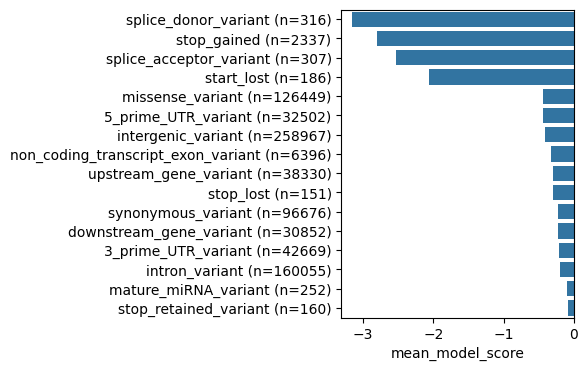

In [109]:
plt.figure(figsize=(3,4))
sns.barplot(
    data=consequence_scores,
    y="consequence", x="mean_model_score", color="C0"
);
plt.ylabel("")
plt.savefig("model_score_by_consequence.svg", bbox_inches='tight')

In [5]:
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.445963,0.180943,0.000041,-2.247958,Common,1.445963
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.122714,0.000958,0.005789,-0.031569,Rare,-1.122714
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.328421,0.000941,0.004241,0.006849,Rare,0.328421
5,Chr5,538,C,T,2,2158,AT5G01010.2,4456,intergenic_variant,-0.043589,0.000927,0.001401,-1.437007,Rare,-0.043589
6,Chr5,540,T,G,2,2194,AT5G01010.2,4454,intergenic_variant,-2.484268,0.000912,0.001881,0.066429,Rare,-2.484268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319359,Chr5,26974850,C,T,2,2028,AT5G67640.1,-4209,intergenic_variant,0.001271,0.000986,0.038742,-0.295663,Rare,0.001271
1319360,Chr5,26974862,G,A,2,2024,AT5G67640.1,-4221,intergenic_variant,1.164779,0.000988,0.440595,0.574454,Rare,1.164779
1319364,Chr5,26974883,A,C,2,2062,AT5G67640.1,-4242,intergenic_variant,0.285308,0.000970,0.029070,0.328652,Rare,0.285308
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.040504,0.000976,0.000014,-1.248585,Rare,-0.040504


In [7]:
odds_ratio, p_value, min_counts = compute_odds_ratio(df[df.consequence=="upstream_gene_variant"], 1e-3, print_table=True)
odds_ratio, p_value, min_counts

Status  ModelScoreTier
Common  High              16232
        Low                   6
Rare    High              22059
        Low                  33
dtype: int64


(4.047146289496351, 0.00030769630324283307, 6)

In [3]:
df = pd.read_parquet("../plantbert/mlm/vep_full_results_512_convnet_ftAth_alone_checkpoint-800000.parquet")
df.rename(columns=dict(chromosome="chrom", pos="start"), inplace=True)
df["end"] = df.start + 1
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.365454,501
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.248447,505
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.776646,506
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.489662,511
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,-0.057389,513
...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.658293,26974898
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.321074,26974908
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.956071,26974914
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.732824,26974919


In [4]:
df = bf.coverage(df, repeats)
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.365454,501,0
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.248447,505,0
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.776646,506,0
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.489662,511,0
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,-0.057389,513,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.658293,26974898,0
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.321074,26974908,0
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.956071,26974914,0
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.732824,26974919,0


In [6]:
df = df.query('coverage == 0')
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.365454,501,0
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.248447,505,0
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.776646,506,0
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.489662,511,0
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,-0.057389,513,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.658293,26974898,0
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.321074,26974908,0
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.956071,26974914,0
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.732824,26974919,0


In [7]:
df = df.sort_values("model_llr")
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage
278453,Chr5,5559261,G,C,132,2230,AT5G16910.1,-2418,"splice_donor_variant,splice_donor_variant,spli...",-10.565787,5559262,0
464310,Chr5,9040859,G,T,2,2222,AT5G25910.1,1999,missense_variant,-10.146180,9040860,0
1209810,Chr5,22484780,G,C,2,2024,AT5G55507.1,932,"downstream_gene_variant,non_coding_transcript_...",-9.966997,22484781,0
1302688,Chr5,24262596,G,T,2,2140,AT5G60290.1,-268,"downstream_gene_variant,non_coding_transcript_...",-9.927591,24262597,0
1395647,Chr5,26097540,C,G,2,2070,AT5G65300.1,-1769,non_coding_transcript_exon_variant,-9.820383,26097541,0
...,...,...,...,...,...,...,...,...,...,...,...,...
186415,Chr5,3591385,C,A,1770,2154,AT5G11250.1,575,"missense_variant,missense_variant,missense_var...",8.094326,3591386,0
630754,Chr5,12223799,C,A,2098,2118,AT5G32590.1,523,stop_gained,8.196587,12223800,0
41306,Chr5,707347,G,T,478,2054,AT5G03020.1,90,"downstream_gene_variant,missense_variant",8.618446,707348,0
1000208,Chr5,18877333,A,C,1990,2088,AT5G46530.1,1808,missense_variant,8.627046,18877334,0


In [8]:
df = df[df.AC/df.AN < 0.5]
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage
278453,Chr5,5559261,G,C,132,2230,AT5G16910.1,-2418,"splice_donor_variant,splice_donor_variant,spli...",-10.565787,5559262,0
464310,Chr5,9040859,G,T,2,2222,AT5G25910.1,1999,missense_variant,-10.146180,9040860,0
1209810,Chr5,22484780,G,C,2,2024,AT5G55507.1,932,"downstream_gene_variant,non_coding_transcript_...",-9.966997,22484781,0
1302688,Chr5,24262596,G,T,2,2140,AT5G60290.1,-268,"downstream_gene_variant,non_coding_transcript_...",-9.927591,24262597,0
1395647,Chr5,26097540,C,G,2,2070,AT5G65300.1,-1769,non_coding_transcript_exon_variant,-9.820383,26097541,0
...,...,...,...,...,...,...,...,...,...,...,...,...
616318,Chr5,11441592,G,T,792,2066,AT5G30495.1,61465,intergenic_variant,7.372154,11441593,0
604195,Chr5,11116598,A,T,2,2060,AT5G29054.1,416,intergenic_variant,7.638703,11116599,0
1174630,Chr5,21920233,G,C,86,2238,AT5G54010.1,956,missense_variant,7.652894,21920234,0
897197,Chr5,17179256,A,T,4,2248,AT5G42840.1,98,"missense_variant,missense_variant",7.791587,17179257,0


In [9]:
df.head(10)

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage
278453,Chr5,5559261,G,C,132,2230,AT5G16910.1,-2418,"splice_donor_variant,splice_donor_variant,spli...",-10.565787,5559262,0
464310,Chr5,9040859,G,T,2,2222,AT5G25910.1,1999,missense_variant,-10.146180,9040860,0
1209810,Chr5,22484780,G,C,2,2024,AT5G55507.1,932,"downstream_gene_variant,non_coding_transcript_...",-9.966997,22484781,0
1302688,Chr5,24262596,G,T,2,2140,AT5G60290.1,-268,"downstream_gene_variant,non_coding_transcript_...",-9.927591,24262597,0
1395647,Chr5,26097540,C,G,2,2070,AT5G65300.1,-1769,non_coding_transcript_exon_variant,-9.820383,26097541,0
1174986,Chr5,21926471,C,A,2,2218,AT5G54030.1,772,"missense_variant,stop_gained",-9.746709,21926472,0
1430559,Chr5,26715192,A,T,14,2238,AT5G66890.1,-809,"3_prime_UTR_variant,stop_gained,stop_gained",-9.714155,26715193,0
271061,Chr5,5426200,C,A,2,2240,AT5G16580.1,1272,stop_gained,-9.706209,5426201,0
1380130,Chr5,25784174,C,G,6,2014,AT5G64510.1,-230,non_coding_transcript_exon_variant,-9.494919,25784175,0
225188,Chr5,4471101,C,A,2,2006,AT5G13840.1,-110,"intron_variant,non_coding_transcript_exon_vari...",-9.361849,4471102,0


In [10]:
df.tail(10)

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage
773451,Chr5,15321689,T,G,282,2218,AT5G38340.1,1182,"missense_variant,missense_variant,missense_var...",6.700293,15321690,0
708732,Chr5,13907407,C,T,184,2216,AT5G35737.1,243,missense_variant,6.782288,13907408,0
232067,Chr5,4623718,C,A,16,2226,AT5G14340.1,351,"5_prime_UTR_variant,splice_region_variant,syno...",7.036128,4623719,0
736341,Chr5,14616339,G,T,8,2208,AT5G37000.1,-1768,intergenic_variant,7.172498,14616340,0
280404,Chr5,5593706,C,T,20,2134,AT5G17020.2,-1018,intergenic_variant,7.224494,5593707,0
616318,Chr5,11441592,G,T,792,2066,AT5G30495.1,61465,intergenic_variant,7.372154,11441593,0
604195,Chr5,11116598,A,T,2,2060,AT5G29054.1,416,intergenic_variant,7.638703,11116599,0
1174630,Chr5,21920233,G,C,86,2238,AT5G54010.1,956,missense_variant,7.652894,21920234,0
897197,Chr5,17179256,A,T,4,2248,AT5G42840.1,98,"missense_variant,missense_variant",7.791587,17179257,0
41306,Chr5,707347,G,T,478,2054,AT5G03020.1,90,"downstream_gene_variant,missense_variant",8.618446,707348,0
